<a href="https://colab.research.google.com/github/Martinmbiro/Pytorch-classification-basics/blob/main/03%20Model%20training%20and%20evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Putting it all together**
> In this notebook, we'll build on the previous notebooks and fit the model to the data. That said, we'll follow the basic PyTorch workflow

> 🔔 **Recall**  
+ This is a _multi-class_ classification problem as we're trying to predict one of 3 species of Iris flowers

In [3]:
# import modules
import torch, matplotlib.pyplot as plt, torch.nn as nn, numpy as np
import torch.nn.functional as F
# specify stylesheet
plt.style.use('fast')

# for type hinting
from typing import Tuple

In [4]:
# set up device
if torch.cuda.is_available():
  device = 'cuda'
elif torch.backends.mps.is_available():
  device = 'mps'
else:
  device = 'cpu'

In [5]:
# device
device

'cuda'

### Loading the data
> I'll use the function we defined in the previous notebook

In [6]:
# define function to load dataset
def load_dataset() -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
  # make necessary imports
  from sklearn import datasets
  # for data preprocessing
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.impute import SimpleImputer
  from sklearn.pipeline import make_pipeline

  # load the dataset
  iris = datasets.load_iris()

  # make pipeline for preprocessing the features
  preprocessor = make_pipeline(
      SimpleImputer(strategy='median'), # handle missing values (if any)
      MinMaxScaler() # scale data from 0 -> 1
  )

  # preprocess the features
  X = preprocessor.fit_transform(iris.data)
  # get labels
  y = iris.target

  # return X, y, target_names
  return X, y, iris.target_names

In [7]:
# load data
X, y, target_names = load_dataset()

In [8]:
# check datatype returned
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

#### Convert data into [`torch.Tensor`](https://pytorch.org/docs/stable/tensors.html#torch-tensor)
> 🔔 **Recall**
+ Recall that the `load_dataset()` function returns `X` and `y` as Numpy's [`ndarray`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html#numpy.ndarray)
+ We'll have to change them to [`torch.Tensor`](https://pytorch.org/docs/stable/tensors.html#torch-tensor)

In [9]:
# convert X and y to Pytorch tensors
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).long()

# confirm type and dtype
type(X), type(y), X.dtype, y.dtype

(torch.Tensor, torch.Tensor, torch.float32, torch.int64)

#### Split data into training and test sets
> For this, we'll use [`sklearn's`](https://scikit-learn.org/stable/index.html) [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [10]:
from sklearn.model_selection import train_test_split

# split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                test_size=0.2, random_state=42,
                                # split in a stratified fashion with ref. to y
                                stratify=y)

# view shapes
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([120, 4]),
 torch.Size([120]),
 torch.Size([30, 4]),
 torch.Size([30]))

### Specifying `Dataset` and `Dataloader`
> ✋ **Info**
+ [`torch.utils.data.TensorDataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) is a utility from [`torch.utils.data`](https://pytorch.org/docs/stable/data.html#module-torch.utils.data) module that allows for creation of datasets from multiple [`Tensors`](https://pytorch.org/docs/stable/tensors.html)
+ [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) combines a dataset and a sampler, and provides an iterable over the given dataset
+ The `batch_size` specified in the `DataLoader` refers to the number of data points considered to calculate the loss value or update weights

In [11]:
from torch.utils.data import TensorDataset, DataLoader
BATCH_SIZE = 16

# TensordataSets for training and testing
train_set = TensorDataset(X_train.to(device), y_train.to(device))
test_set = TensorDataset(X_test.to(device), y_test.to(device))

# DataLoaders for training and testing
train_loader = DataLoader(dataset=train_set, shuffle=True,
                          batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_set, shuffle=False,
                          batch_size=BATCH_SIZE)

### Build a neural network
> ✋ **Info**  

> For the Neural Network,
+ We'll stack [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#linear) with [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) such that we'll end up with two _hidden layers_ between the _input_ and _output layers._
+ The hidden layers will have `8` neurons
+ [`nn.Relu`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) activation function will be used to introduce non-linearity
+ Since this is a multi-class classification task (we have `3` distinct classes) , the output layer will have `3` neurons

In [35]:
# define a function to return a model
def get_model(device):
  torch.manual_seed(42)

  # stacking the layers
  model = nn.Sequential(
      nn.Linear(in_features=X_train.shape[1], out_features=8), # input to layer 1
      nn.ReLU(),
      nn.Linear(8, 8), # hidden layer 1 -> hidden layer 2
      nn.ReLU(),
      nn.Linear(8, 3), # hidden layer 2 -> output layer
  ).to(device)
  return model

In [ ]:
# get a model
model = get_model()

#### Visualize model info
> To do this, we'll use [`torchinfo`](https://github.com/TylerYep/torchinfo)

In [13]:
# install the library
!pip install torchinfo
# import summary
from torchinfo import summary

In [14]:
summary(model, input_size=(X_train.shape[1],))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [3]                       --
├─Linear: 1-1                            [8]                       40
├─ReLU: 1-2                              [8]                       --
├─Linear: 1-3                            [8]                       72
├─ReLU: 1-4                              [8]                       --
├─Linear: 1-5                            [3]                       27
Total params: 139
Trainable params: 139
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### Early stopping
> 💎 **Pro Tip**

> [Early stopping](https://www.linkedin.com/advice/1/what-benefits-drawbacks-early-stopping#:~:text=Early%20stopping%20is%20a%20form,to%20increase%20or%20stops%20improving.) is a mechanism of stopping training when the validation loss stops improving; with a view to preventing _overfitting_ on the training data
+ Here, we'll create a class to take care of _early-stopping_

In [15]:
# define a class for early stopping
from copy import deepcopy

class EarlyStopping:
  '''
    patience -> the number of epochs to wait after the last improvement
                before stopping

    counter -> how many epochs have passed since the last improvement

    min_delta -> how much of a difference in loss is to be considered
          worthy to continue training
  '''
  def __init__(self, score_type:str, min_delta:float=0.0, patience:int=5):
    self.counter = 0
    self.patience = patience
    self.min_delta = min_delta
    self.score_type = score_type
    self.best_epoch = None
    self.best_score = None
    self.best_state_dict = None
    self.stop_early = False

    if (self.score_type != 'metric') and (self.score_type != 'loss'):
      err_msg = 'score_type can only be "metric" or "loss"'
      raise Exception(err_msg)

  def __call__(self, model:nn.Module, ep:int, ts_score:float):
    if self.best_epoch is None: # for first time:
      self.best_epoch = ep # store current epoch
      self.best_score = ts_score # store current loss as best loss
      # make a copy of current model's state_dict
      self.best_state_dict = deepcopy(model.state_dict())

    # if previous loss - current loss exceeds min_delta: (for loss function)
    elif (self.best_score - ts_score >= self.min_delta) and (self.score_type == 'loss'):
      self.best_epoch = ep # store current epoch
      self.best_score = ts_score # store current loss as best
      # make a copy of current model's state_dict
      self.best_state_dict = deepcopy(model.state_dict())
      self.counter = 0 # restore counter to zero

    # if current metric - previous. metric exceeds min_delta: (for metric)
    elif (ts_score - self.best_score >= self.min_delta) and (self.score_type == 'metric'):
      self.best_epoch = ep # store current epoch
      self.best_score = ts_score # store current loss as best
      # make a copy of current model's state_dict
      self.best_state_dict = deepcopy(model.state_dict())
      self.counter = 0 # restore counter to zero

    else: # otherwise
      self.counter += 1 # increment counter each time
      if self.counter >= self.patience:
        self.stop_early = True


### Loss function and optimizer
> ✋ **Info**
+ Since this is a _multi-class classification_ problem, we'll use [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#crossentropyloss) as the loss function  
+ Also, we'll use [`torch.optim.Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#adam) as optimizer

> 📝 **Note**

> [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#crossentropyloss) criterion computes the cross entropy loss between input [**`logits`**](https://www.linkedin.com/pulse/understanding-logits-fundamental-concept-machine-aina-temiloluwa-7d3ff#:~:text=Logits%20are%20a%20fundamental%20concept,it%20is%20transformed%20into%20probabilities.) and target

In [16]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
opt = torch.optim.Adam(model.parameters(), # model parameters
                       lr=0.001) # learning rate

### Model training
> Here, we'll write a loop for training and validation

In [17]:
# declare empty lists to store epoch, train & test loss, f1_score
train_losses, test_losses, ep_list, train_f1, test_f1 = [], [], [], [], []
# epochs
epochs = 200

# instantiate early stopping object
esp = EarlyStopping(patience=10, score_type='metric')

In [18]:
# import sklearn's f1 score
from sklearn.metrics import f1_score

# define training and testing functions
def training_fn(model, optimizer, loss_fn, dataloader) -> Tuple[float, float]:
  # empty lists to store f1_score and loss
  tr_f1, tr_ls = [], []
  # set model in training mode
  model.train()
  for x_train, y_train in dataloader: # for each batch in training DataLoader:
    # zero_grad
    opt.zero_grad()

    # forward pass
    logits = model(x_train)

    # Softmax activation function (since this is multiclass classification)
    # (to convert logits -> prediction probabilities)
    # followed by self.argmax to find the highest class probability
    y_preds = F.softmax(model(x_train), dim=1).argmax(dim=1)
    tr_f1.append(f1_score(y_true=y_train.cpu().numpy(), # tensor -> ndarray
                          y_pred=y_preds.cpu().numpy(), # tensor -> ndarray
                          average='micro'))

    # loss
    loss = loss_fn(logits, y_train)
    tr_ls.append(loss.item())

    # back propagation
    loss.backward()

    # gradient descent
    optimizer.step()

  # average training loss
  mean_train_loss, mean_train_f1 = np.mean(tr_ls), np.mean(tr_f1)

  return mean_train_loss, mean_train_f1

def testing_fn(model, loss_fn, dataloader) -> Tuple[float, float]:
  # empty lists to store f1_score and loss
  ts_f1, ts_ls = [], []
  # set model in eval mode
  model.eval()
  for x_test, y_test in dataloader:
    # make predictions
    logits = model(x_test)

    # loss
    loss = loss_fn(logits, y_test)
    # Softmax activation function (since this is multiclass classification)
    # (to convert logits -> prediction probabilities)
    # followed by self.argmax to find the highest class probability
    y_preds = F.softmax(model(x_test), dim=1).argmax(dim=1)

    ts_ls.append(loss.item())
    ts_f1.append(f1_score(y_true=y_test.cpu().numpy(),
                          y_pred=y_preds.cpu().numpy(),
                          average='micro'))

  mean_test_f1, mean_test_ls = np.mean(ts_f1), np.mean(ts_ls)

  return mean_test_ls, mean_test_f1

In [19]:
%%time
torch.manual_seed(42)
torch.cuda.manual_seed(42)

for ep in range(1, epochs+1):
  # train
  tr_loss, tr_f1 = training_fn(model, opt, loss_fn, train_loader)
  # test
  ts_loss, ts_f1, = testing_fn(model, loss_fn, test_loader)

  # store returned metrics in appropriate lists
  train_losses.append(tr_loss)
  test_losses.append(ts_loss)
  train_f1.append(tr_f1)
  test_f1.append(ts_f1)
  ep_list.append(ep) # append epoch

  # print progress for each epoch
  if ep%5 == 0:
    print(f'Epoch: {ep} | Train Loss: {tr_loss:.4f} | Test Loss: {ts_loss:.4f}')

  # early stopping (based on f1_score classification metric)
  esp(model, ep=ep, ts_score=ts_f1)
  if esp.stop_early == True:
    break # break training loop if early stopping is triggered

# at the end of optimization loop:
print(f'\nSTOPPED | Best Epoch: {esp.best_epoch} | Best f1-score: {esp.best_score:.4f}\n')

Epoch: 5 | Train Loss: 1.1100 | Test Loss: 1.1135
Epoch: 10 | Train Loss: 1.1043 | Test Loss: 1.1019
Epoch: 15 | Train Loss: 1.0851 | Test Loss: 1.0831
Epoch: 20 | Train Loss: 1.0470 | Test Loss: 1.0471
Epoch: 25 | Train Loss: 0.9929 | Test Loss: 0.9873
Epoch: 30 | Train Loss: 0.9051 | Test Loss: 0.9030
Epoch: 35 | Train Loss: 0.7481 | Test Loss: 0.7418
Epoch: 40 | Train Loss: 0.6050 | Test Loss: 0.6175
Epoch: 45 | Train Loss: 0.5263 | Test Loss: 0.5331
Epoch: 50 | Train Loss: 0.4485 | Test Loss: 0.4753
Epoch: 55 | Train Loss: 0.4208 | Test Loss: 0.4351
Epoch: 60 | Train Loss: 0.3882 | Test Loss: 0.3962
Epoch: 65 | Train Loss: 0.3392 | Test Loss: 0.3627
Epoch: 70 | Train Loss: 0.3069 | Test Loss: 0.3347
Epoch: 75 | Train Loss: 0.2890 | Test Loss: 0.3106
Epoch: 80 | Train Loss: 0.2676 | Test Loss: 0.2897
Epoch: 85 | Train Loss: 0.2363 | Test Loss: 0.2716

STOPPED | Best Epoch: 76 | Best f1-score: 0.9643

CPU times: user 3.09 s, sys: 116 ms, total: 3.21 s
Wall time: 3.54 s


> 📝 **Note**  
> The _early-stopping_ mechanism uses a classification metric, `f1_score` since in this case, it would be better at monitoring overfitting as opposed to the `CrossEntropyLoss`

### Model evaluation
> Here, we'll evaluate the model by plotting loss curves from the optimization loop, as well as analysing various classification metrics.  

> ❗ **Disclaimer**
+ I'll be using [scikit-learn's classification metrics](https://scikit-learn.org/stable/api/sklearn.metrics.html#classification-metrics)
+ Check out my previous GitHub repository on evaluation of classification models using scikit-learn on the link provided [here](https://github.com/Martinmbiro/Imbalanced-Datasets-and-Evaluating-Classification-Models)

In [20]:
# overwrite model with best model's state_dict
model.load_state_dict(esp.best_state_dict)

# return y_preds & y_proba as numpy arrays
with  torch.inference_mode():
  model.eval()
  y_preds = F.softmax(model(X_test.to(device)), dim=1).argmax(dim=1).cpu().numpy()
  y_proba = F.softmax(model(X_test.to(device)), dim=1).cpu().numpy()

In [21]:
# function to plot train and test results
def plot_train_results(ep_list:list, train_score:list, test_score:list,
                       best_epoch:int, ylabel, title:str):
  f, ax = plt.subplots(figsize=(5, 3), layout='constrained')

  # train loss
  ax.plot(ep_list, train_score, label='Training',
          linewidth=1.7, color='#0047ab')

  # test loss
  ax.plot(ep_list, test_score, label='Validation',
          linewidth=1.7, color='#990000')
  # vertical line (for early stopping)
  if best_epoch is not None:
    ax.axvline(best_epoch, linestyle='--', color='#000000', linewidth=1.0,
             label=f'Best ep ({best_epoch})')

  # axis, title
  ax.set_title(title, weight='black')
  ax.set_ylabel(ylabel)
  ax.set_xlabel('Epoch')
  ax.tick_params(axis='both', labelsize=9)
  plt.grid(color='#e5e4e2')

  # legend
  f.legend(fontsize=9, loc='upper right',
          bbox_to_anchor=(1.28, 0.93),
          fancybox=False)

  plt.show()

In [22]:
# function to plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(y_true:np.ndarray, y_pred:np.ndarray):
  # axes for plotting
  _, ax = plt.subplots(figsize=(3.0,3.0), layout='constrained')

  ConfusionMatrixDisplay.from_predictions(
      y_true=y_true,
      y_pred=y_preds, cmap='Blues',
      colorbar=False, ax=ax)

  # xaxis position
  ax.xaxis.set_label_position('top')
  ax.xaxis.tick_top()

  # labels
  ax.set_ylabel('True Labels', weight='black')
  ax.set_xlabel('Predicted Labels', weight='black',
                color='#dc143c')

  plt.show()

In [23]:
# function to plot multiclass ROC curve (One vs Rest apporach)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

def plot_multiclass_roc_curve(y_true:np.ndarray, y_proba:np.ndarray):
  # binarize y_pred
  y_bin = label_binarize(y=y_true, classes=y.unique())

  # plot and figure
  fig, ax = plt.subplots(figsize=(4.0, 3.5), layout='constrained')

  for i in (range(len(y.unique()))):
    # calculate roc_curve
    fpr, tpr, t = roc_curve(y_bin[:, i], y_proba[:, i])
    # roc_auc_score
    auc_sc = auc(fpr, tpr)

    # plot
    ax.plot(fpr, tpr, linestyle='-', linewidth=1.7,
            label=f'Class {i} vs rest (AUC = {auc_sc:.3f})')

  # title, labels
  ax.set_ylabel('True Positive Rate (tpr)')
  ax.set_xlabel('False Positive Rate (fpr)')
  ax.set_title('Multiclass ROC Curve (OvR)', weight='black')

  fig.legend(fontsize=9,
        loc='upper right',
        bbox_to_anchor=(1.65, 0.94),
        fancybox=False)

  plt.show()

#### Plot loss curves

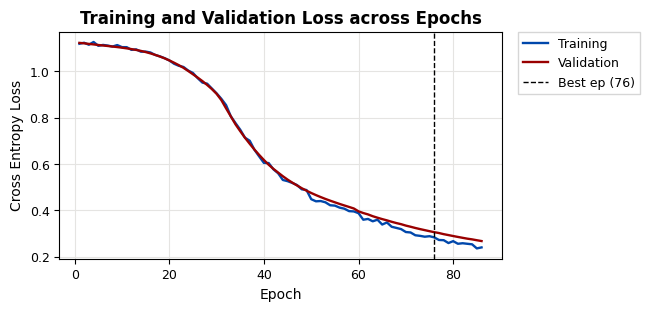

In [24]:
# plot losses across epochs
plot_train_results(ep_list=ep_list, train_score=train_losses,
          test_score=test_losses, best_epoch=esp.best_epoch,
          ylabel='Cross Entropy Loss',
          title='Training and Validation Loss across Epochs')

#### Plot [`f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) across epochs
> ✋ **Info**  
+ Since this is a multi-class classification problem, and there's no positive and negative class, I chose `f1_score` as it's the _harmonic mean_ of the [`recall_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#recall-score) and [`precision_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)

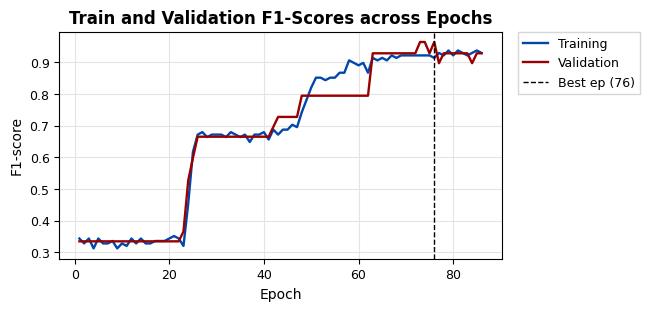

In [25]:
# plot f1 scores across epochs
plot_train_results(ep_list=ep_list, train_score=train_f1, test_score=test_f1,
            ylabel='F1-score',
            title='Train and Validation F1-Scores across Epochs',
            best_epoch=esp.best_epoch, )

#### [`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#accuracy-score)

In [26]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_true=y_test.numpy(),
                     y_pred=y_preds)
# print
print(f'Model Accuracy: {acc:.4f}')

Model Accuracy: 0.9667


#### [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#classification-report)

In [27]:
from sklearn.metrics import classification_report

cr = classification_report(y_true=y_test.numpy(),
                           y_pred=y_preds,
                           zero_division=np.nan)
# print
print(cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



#### [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

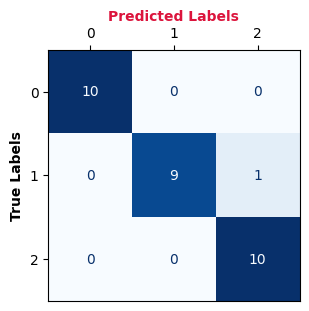

In [28]:
# plot confusion matrix
plot_confusion_matrix(y_true=y_test.numpy(), # tensor -> numpy
                      y_pred=y_preds)

#### `roc` curve (OvR Multiclass approach)
> ✋ **Info**
+ An ROC curve is a graph that shows how well a classification model performs in distinguishing between classes (usually a binary classification task between a positive class, `1` and negative class `0`)
+ For insight on the intuition behind a multi-class ROC curve (OvR approach), follow the link to a previous GitHub repository [`here`](https://github.com/Martinmbiro/Crop-Recommendation---a-classification-problem/blob/main/03%20Modelling%20%26%20Evaluation.ipynb)

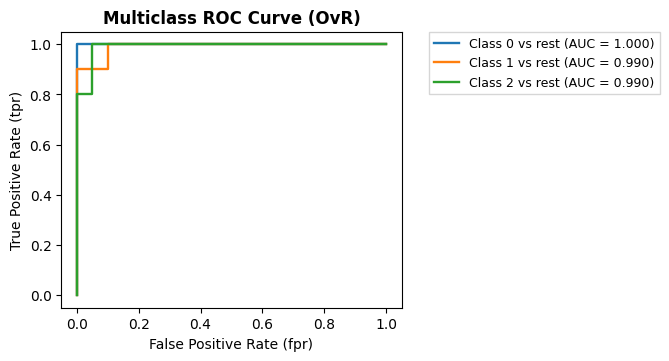

In [29]:
# plot roc_curve
plot_multiclass_roc_curve(y_true=y_test.numpy(),
                          y_proba=y_proba)

#### Overall [`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#roc-auc-score)
> ✋ **Info**
+ The AUC metric is a single value that measures the performance of a model by representing the probability that a model will rank a randomly chosen positive example higher than a negative one.

In [30]:
# calculate roc_auc_score (for multiclass classification)
ras = roc_auc_score(y_true=y_test.numpy(),
                    y_score=y_proba,
                    multi_class='ovr')
# print
print(f'roc_auc_score: {ras:.4f}')

roc_auc_score: 0.9933


### Saving the model
> I'll be using the [`pathlib`](https://docs.python.org/3/library/pathlib.html) libary to create a path. Also, we'll be following the recommended way of saving a model from Pytorch's documentation lined [`here`](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-state-dict-recommended)

In [33]:
# import Pathlib
from pathlib import Path

# parent directory
PARENT = Path('models')
PARENT.mkdir(parents=True, exist_ok=True)

# model path
MODEL_PATH = PARENT/'iris_model.pth'
print(MODEL_PATH)

models/iris_model.pth


In [34]:
# save model's state_dict
torch.save(model.cpu().state_dict(), MODEL_PATH)
print(f"MODEL'S state_dict saved to: {MODEL_PATH}")

MODEL'S state_dict saved to: models/iris_model.pth


#### Loading the model
> Pytorch's recommended way of loading saved model's `state_dict` is linked [`here`](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-state-dict-recommended)

In [37]:
# create a model object
loaded_model = get_model(device)

# overwrite stat_dict
loaded_model.load_state_dict(
    torch.load(f=MODEL_PATH, weights_only=True))

<All keys matched successfully>

### Conclusion

> 👏 **Bam!**  

> Based on the overall classification metrics, the model's performance seems incredible! We were able to achieve the following (on a scale of `0` -> `1`):
+ A weighted `precision`, `recall` and `f1_score` of `0.97`
+ An overall model accuracy of `0.9667`
+ An overall `roc_auc_score` of `0.9933`

> ❗ **Disclaimer**
+ In this exercise, we're dealing with tabular data. However, neural networks are generally preferred while working with unstructured data such as photos, text and audio.
+ This has just been a demonstration, since it might be easier to grasp and visualize.
+ However, tree based models such as `RandomForestClassifier`, `xgboost` and `catboost` offer incredible performance for structured (tabular) data. See how I demonstrate working with these models in my repositories linked [`here`](https://github.com/Martinmbiro/Crop-Recommendation---a-classification-problem), [`here`](https://github.com/Martinmbiro/Gradient-Boosting-with-CatBoost-for-Classification), [`here`](https://github.com/Martinmbiro/Yield-Estimation---a-regression-problem) and [`here`](https://github.com/Martinmbiro/Train-and-evaluate-regression-models)

> ▶ **Up Next**
+ Pytorch [Computer Vision](https://www.ibm.com/think/topics/computer-vision#:~:text=Computer%20vision%20is%20a%20field,they%20see%20defects%20or%20issues.)

> Until next time 👋